In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

In [5]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    df.drop(["Unnamed: 0", 'row_id'], axis=1, inplace=True)

    return df

In [6]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

In [7]:
date_set_path = "../temp_sets/"

In [8]:
labevents_sample_df = read_csv_no_rowid(date_set_path + "labevents.csv")

In [9]:
labevents_sample_df.head()

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,11290,137961.0,51251,2173-11-19 19:45:00,0,0.0,%,NaN
1,11290,137961.0,51252,2173-11-19 19:45:00,NORMAL,NaN,NaN,NaN
2,11290,137961.0,51254,2173-11-19 19:45:00,8,8.0,%,NaN
3,11290,137961.0,51255,2173-11-19 19:45:00,0,0.0,%,NaN
4,11290,137961.0,51256,2173-11-19 19:45:00,50,50.0,%,abnormal


In [10]:
# Drop some null value
labevents_sample_df.dropna(subset=['subject_id', 'hadm_id'], inplace=True, axis=0)

In [13]:
# Drop some columns
labevents_sample_df.drop(['flag'], axis=1, inplace=True)

In [14]:
nan_count(labevents_sample_df)

Total columns: 7
Total rows: 512612
--------------
subject_id        0
hadm_id           0
itemid            0
charttime         0
value            25
valuenum      47217
valueuom      55336
dtype: int64


In [15]:
# Deal with null values
labevents_sample_df['value'].fillna(value='Na', inplace=True)
labevents_sample_df['valuenum'].fillna(value='Na', inplace=True)
labevents_sample_df['valueuom'].fillna(value='Na', inplace=True)

In [16]:
labevents_sample_df.dtypes

subject_id      int64
hadm_id       float64
itemid          int64
charttime      object
value          object
valuenum       object
valueuom       object
dtype: object

In [17]:
labevents_sample_df['hadm_id'] = labevents_sample_df['hadm_id'].astype(int)

labevents_sample_df['charttime'] = pd.to_datetime(labevents_sample_df['charttime'])

In [18]:
labevents_sample_df.dtypes

subject_id             int64
hadm_id                int32
itemid                 int64
charttime     datetime64[ns]
value                 object
valuenum              object
valueuom              object
dtype: object

In [19]:
len(labevents_sample_df)

512612

---

## Build model

In [20]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations
from sdv.constraints import Inequality

In [21]:
labevents_sample_df.columns

Index(['subject_id', 'hadm_id', 'itemid', 'charttime', 'value', 'valuenum',
       'valueuom'],
      dtype='object')

In [27]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id']
)
fixed_itemid_value_valueuom_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valuenum', 'valueuom']
)

In [28]:
labevents_constraints = [fixed_subject_hadm_icustay_constraint, fixed_itemid_value_valueuom_constraint]

In [38]:
model = CTGAN(
    constraints=labevents_constraints, 
    batch_size=1000,
    generator_lr=0.0005,
    discriminator_lr=0.0005,
    cuda=True, 
    verbose=True, 
    epochs=200)

In [39]:
len(labevents_sample_df)

512612

In [40]:
train_data = labevents_sample_df.loc[0:1000, : ]
model.fit(train_data)

Epoch 1, Loss G:  4.0899,Loss D: -0.0000
Epoch 2, Loss G:  3.8797,Loss D: -0.0049
Epoch 3, Loss G:  3.9739,Loss D: -0.0080
Epoch 4, Loss G:  3.8791,Loss D: -0.0067
Epoch 5, Loss G:  3.8518,Loss D:  0.0014
Epoch 6, Loss G:  3.8730,Loss D:  0.0030
Epoch 7, Loss G:  3.8487,Loss D: -0.0073
Epoch 8, Loss G:  3.9064,Loss D:  0.0029
Epoch 9, Loss G:  3.8265,Loss D:  0.0174
Epoch 10, Loss G:  3.8669,Loss D:  0.0107
Epoch 11, Loss G:  3.8281,Loss D:  0.0257
Epoch 12, Loss G:  3.8321,Loss D:  0.0136
Epoch 13, Loss G:  3.6152,Loss D:  0.0152
Epoch 14, Loss G:  3.7798,Loss D: -0.0132
Epoch 15, Loss G:  3.8756,Loss D: -0.0225
Epoch 16, Loss G:  3.7993,Loss D: -0.0449
Epoch 17, Loss G:  3.9483,Loss D: -0.0561
Epoch 18, Loss G:  3.8218,Loss D: -0.0533
Epoch 19, Loss G:  3.7178,Loss D: -0.0511
Epoch 20, Loss G:  3.7299,Loss D: -0.0273
Epoch 21, Loss G:  3.6264,Loss D:  0.0240
Epoch 22, Loss G:  3.6009,Loss D:  0.0434
Epoch 23, Loss G:  3.6166,Loss D:  0.0775
Epoch 24, Loss G:  3.5491,Loss D:  0.0907
E

In [41]:
model.save("../labevents_model.pkl")

In [42]:
# model = CTGAN.load(("/content/drive/MyDrive/MSc Project/labevents_model.pkl"))

In [43]:
sample = model.sample(num_rows=1000)

Sampling rows: 100%|██████████| 1000/1000 [00:00<00:00, 8839.55it/s]


In [44]:
len(sample)

1000

In [45]:
nan_count(sample)

Total columns: 7
Total rows: 1000
--------------
subject_id    0
hadm_id       0
itemid        0
charttime     0
value         0
valuenum      0
valueuom      0
dtype: int64


In [46]:
sample.dtypes

subject_id             int64
hadm_id                int32
itemid                 int64
charttime     datetime64[ns]
value                 object
valuenum              object
valueuom              object
dtype: object

In [47]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.834784417594357

In [48]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.5652948444179976

<AxesSubplot:xlabel='itemid', ylabel='value'>

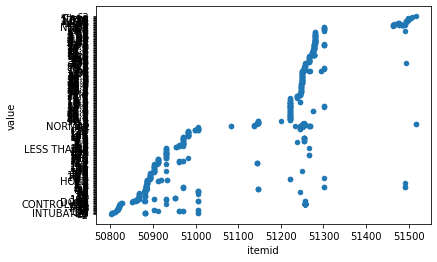

In [49]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

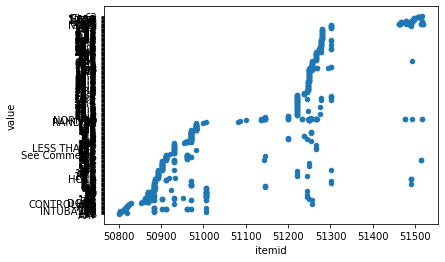

In [50]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:>

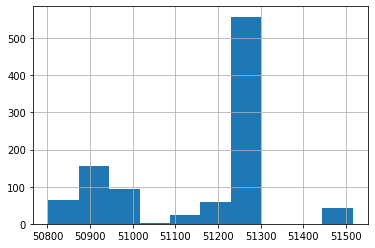

In [51]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

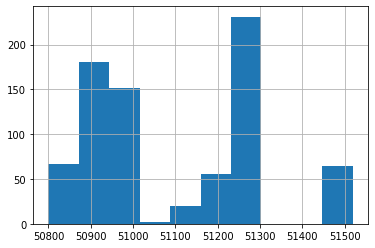

In [52]:
train_data.sort_values('itemid')['itemid'].hist()

In [76]:
# evaluate(sample, train_data, aggregate=False)